In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

In [17]:
import seaborn as sns

In [30]:
accident_df = pd.read_csv('accident.csv')
accident_df.head()


,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0


In [31]:
#cleaning
accident_df['Survived'] = accident_df['Survived'].astype(int)
accident_df = accident_df.dropna()

#creating dummies for categorical variables
accident_df = pd.get_dummies(accident_df, columns=['Gender', 'Helmet_Used', 'Seatbelt_Used'], drop_first=True)

#scaling Age and Speed of impact to prevent numerical instability
accident_df['Age'] = (accident_df['Age'] - accident_df['Age'].mean()) / accident_df['Age'].std()
accident_df['Speed_of_Impact'] = (accident_df['Speed_of_Impact'] - accident_df['Speed_of_Impact'].mean()) / accident_df['Speed_of_Impact'].std()
accident_df.head()

,Age,Speed_of_Impact,Survived,Gender_Male,Helmet_Used_Yes,Seatbelt_Used_Yes
0,0.843598,-1.438095,1,False,False,False
1,1.709977,-0.809002,1,False,False,True
2,0.177152,-0.809002,0,True,True,True
3,-0.755872,1.541817,0,True,False,True
4,1.110176,-1.007663,0,False,True,True


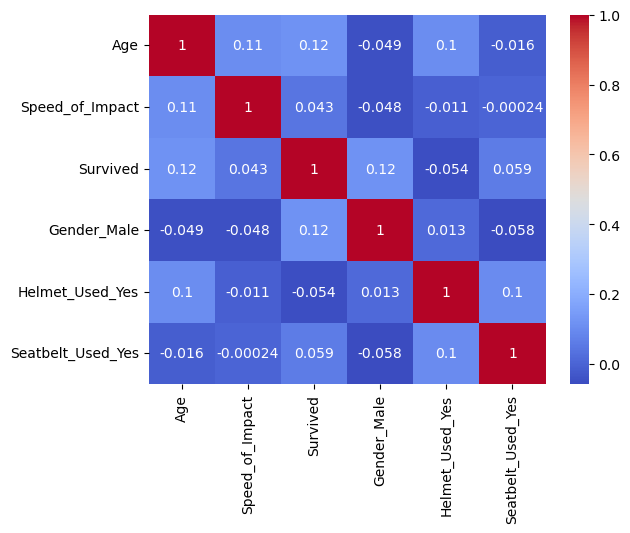

In [20]:
sns.heatmap(accident_df.corr(), annot=True, cmap="coolwarm")
plt.show()

## Q1

In [21]:
#implementing a Bayesial Logistic regression model
n,p = len(accident_df), 5

#converting categorical predictors into numeric type for pymc convergence
X,y = accident_df[['Age','Gender_Male','Speed_of_Impact','Helmet_Used_Yes','Seatbelt_Used_Yes']].astype(int).values, accident_df['Survived']

with pm.Model() as logit_model:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    logits = pm.math.dot(X, betas)
    y = pm.Bernoulli('y', p=1/(1+pm.math.exp(-logits)), observed=y)
    
with logit_model:
    idata = pm.sample(draws=2000, tune=1000, target_accept=0.9, cores=4, random_seed=42)
    #high target accept along with tune=1000 was set due to convergence problems on previous iterations

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


In [22]:
az.summary(idata,round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.24645,0.22715,-0.17362,0.67671,0.00237,0.00257,9214.57516,5429.67957,1.00089
betas[1],0.40394,0.25006,-0.05410,0.89695,0.00266,0.00288,8944.41276,5549.63764,1.00094
betas[2],0.09095,0.21978,-0.31688,0.51008,0.00234,0.00276,8842.86827,5753.56005,1.00011
betas[3],-0.35061,0.25019,-0.81605,0.12190,0.00288,0.00272,7534.53292,6170.14271,1.00014
betas[4],0.19135,0.24252,-0.26114,0.64763,0.00273,0.00259,7925.18358,6337.30689,1.00064


We see that we have achieved robust convergence results. Our ess_bulk for all betas are well above 50% of the number of draws. Even the ess_tails are high implying good exploration of the bulk and tail of the posterior. All the r_hats are below 1.01 implying good convergence for all beta chains. 

However, if we look at the means of all betas, the ratio between the mean and standard deviation isn't very high. In other words, we have a pretty high standard devation. This could be because we didn't use a multivariate normal prior for beta which would've modelled the dependence structure of the betas. Without that, there is added uncertainty on how much the betas capture the true effect of the predictor which is what the standard deviation represents. 

## Q2

In [23]:
df_wine = pd.read_csv('winequality-red.csv', sep=';')
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


The following dataset contains chemical characteristics of Red Wine. For the purpose of the multivariate regression, we will pick the following as response variables:
- quality
- alcohol (concentration)
- pH
- density

This is because these variables are likely correlated with each other i.e their residuals may be correlated which is what the multivariate model accounts for.


In [24]:
df_wine_small= df_wine[0:100]

In [25]:
#running Bayesian Multivariate regression model
n,m,p = 100,4,8
X = df_wine_small[['fixed acidity','volatile acidity', 'citric acid','residual sugar','chlorides','free sulfur dioxide',
                   'total sulfur dioxide','sulphates']].values
y = df_wine_small[['alcohol','quality','density','pH']]

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_Y.fit_transform(y)

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L, observed=y)   
    
    idata_2 = pm.sample(draws=1000, cores=4,target_accept=0.9, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 212 seconds.


In [26]:
az.summary(idata_2, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.90528,0.13320,0.67122,1.16266,0.00186,0.00222,5398.72349,3428.10825,1.00027
"Sigma[0, 1]",0.17941,0.09427,0.00535,0.35128,0.00135,0.00166,4960.03168,3162.42767,1.00096
"Sigma[0, 2]",-0.23006,0.06418,-0.35480,-0.11592,0.00091,0.00107,5143.91913,2926.05652,1.00239
"Sigma[0, 3]",0.29381,0.06729,0.16890,0.41417,0.00098,0.00108,4811.88368,3277.04861,1.00059
"Sigma[1, 0]",0.17941,0.09427,0.00535,0.35128,0.00135,0.00166,4960.03168,3162.42767,1.00096
"Sigma[1, 1]",0.90716,0.13904,0.66781,1.17044,0.00199,0.00237,5294.07107,3151.30369,1.00206
"Sigma[1, 2]",-0.09502,0.06204,-0.21899,0.01593,0.00092,0.00099,4565.78226,2781.78425,1.00211
"Sigma[1, 3]",0.00076,0.05960,-0.11463,0.10710,0.00089,0.00089,4537.27460,2965.05008,1.00045
"Sigma[2, 0]",-0.23006,0.06418,-0.35480,-0.11592,0.00091,0.00107,5143.91913,2926.05652,1.00239
"Sigma[2, 1]",-0.09502,0.06204,-0.21899,0.01593,0.00092,0.00099,4565.78226,2781.78425,1.00211


In [27]:
n,m,p = 100,5,7
X = df_wine_small[['fixed acidity','volatile acidity', 'citric acid','chlorides','free sulfur dioxide',
                   'total sulfur dioxide','sulphates']].values
y = df_wine_small[['alcohol','quality','density','pH','residual sugar']]

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_Y.fit_transform(y)

with pm.Model() as MNV_LKJ:
    
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L, observed=y)   
    
    idata_2_2 = pm.sample(draws=1000, cores=4,target_accept=0.9, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 266 seconds.


In [28]:
az.summary(idata_2_2, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Sigma[0, 0]",0.93789,0.13729,0.69048,1.19986,0.00188,0.00256,5836.75542,2620.94955,0.99966
"Sigma[0, 1]",0.18322,0.09770,0.00561,0.37024,0.00126,0.00186,6162.46605,2745.99163,1.00004
"Sigma[0, 2]",-0.16067,0.07782,-0.29906,-0.01037,0.00106,0.00126,5351.50117,2903.94116,1.00042
"Sigma[0, 3]",0.29359,0.06563,0.17685,0.41968,0.00084,0.00112,6442.22764,3036.57788,1.00150
"Sigma[0, 4]",0.17802,0.10277,-0.00658,0.38010,0.00140,0.00178,5658.39347,2896.59272,1.00021
...,...,...,...,...,...,...,...,...,...
packed_L[10],0.18332,0.10243,-0.01548,0.36809,0.00135,0.00169,5806.46821,2985.26043,1.00033
packed_L[11],-0.01633,0.09807,-0.19841,0.17457,0.00133,0.00155,5454.59200,3209.86948,1.00125
packed_L[12],0.60724,0.08844,0.44670,0.77498,0.00121,0.00155,5559.69803,2725.42372,1.00289
packed_L[13],-0.33169,0.07340,-0.47381,-0.19992,0.00098,0.00114,5655.40281,3152.29902,1.00024


In our Bayesian multivariate regression model, we examined the impact of different dataset sizes on posterior estimates, focusing on the response variables: quality, alcohol, pH, and density.

Findings from Different Dataset Sizes:

- **Posterior Means & Standard Deviations**:

Between the first and second specifications, the posterior means and standard deviations of the sigma matrix did not show large deviations.
However, for the packed Cholesky decomposition (L), the second specification (with a larger dataset) resulted in noticeably lower values in the initial few rows.

- **Impact of Increasing Response Variables**:

Expanding the number of response variables altered the covariance structure of residuals, leading to changes in posterior distributions.
The correlations between response variables influenced the posterior uncertainty in the beta coefficients.

- **Choice of Dataset Size for Analysis**:

Given that posterior distributions remained relatively stable across specifications but computation time increased, a moderate dataset size (e.g., 200 samples) is optimal for balancing accuracy and computational efficiency.

## Q3

For this multivariate classification, we will model the following two dependent binary response variables:

- Gender
- Survived

I am interested in exploring whether there is any dependence structure between Gender and survival probability.


In [14]:
n,m,p = len(accident_df),2,4
X = accident_df[['Age','Speed_of_Impact','Helmet_Used_Yes','Seatbelt_Used_Yes']].astype(int).values
y = accident_df[['Gender_Male','Survived']].astype(int).values
with pm.Model() as classifier:
    L,R,std = pm.LKJCholeskyCov("L", n=m, eta=2.0,
                                sd_dist=pm.Exponential.dist(1.0, shape=m),
                                compute_corr=True)

    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    z = pm.MvNormal('z', mu=X@betas, chol=L, shape = (n,m))
    y_obs = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y)
    
    #step_m= pm.Metropolis(scaling=1, tuning=True)

    idata3 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 303 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1283 divergences after tuning. Increase `target_accept` or reparameterize.


In [15]:
az.summary(idata3, round_to=5)

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],1.82545,0.79597,0.44699,3.23883,0.26939,0.07969,8.65690,16.40936,1.41434
L[1],0.51788,0.34926,-0.03599,1.20547,0.03325,0.03713,134.06141,133.06273,1.02479
L[2],1.86648,0.65658,0.73533,3.12440,0.13761,0.06421,26.16893,46.49759,1.12217
"L_corr[0, 0]",1.00000,0.00000,1.00000,1.00000,0.00000,NaN,4000.00000,4000.00000,NaN
"L_corr[0, 1]",0.26729,0.15747,-0.01047,0.59686,0.01162,0.01622,231.77723,93.54243,1.05013
...,...,...,...,...,...,...,...,...,...
"z[193, 1]",1.74018,1.52661,-0.70849,4.84729,0.07417,0.04091,439.72111,1070.59734,1.00397
"z[194, 0]",1.25745,1.70947,-1.63911,4.82576,0.29381,0.23397,41.13846,61.22005,1.07071
"z[194, 1]",1.78241,1.80504,-1.31149,5.25439,0.30640,0.33392,59.07517,27.42990,1.05612
"z[195, 0]",-1.29949,1.47162,-4.28326,1.08086,0.19576,0.07355,56.90637,379.85244,1.05314


In [33]:
n,m,p = len(accident_df),3,3
X = accident_df[['Age','Speed_of_Impact','Seatbelt_Used_Yes']].astype(int).values
y = accident_df[['Gender_Male','Survived','Helmet_Used_Yes']].astype(int).values
with pm.Model() as classifier:
    L,R,std = pm.LKJCholeskyCov("L", n=m, eta=2.0,
                                sd_dist=pm.Exponential.dist(1.0, shape=m),
                                compute_corr=True)

    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    z = pm.MvNormal('z', mu=X@betas, chol=L)
    y_obs = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=y)
    
    #step_m= pm.Metropolis(scaling=1, tuning=True)

    idata4 = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, betas, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 637 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1227 divergences after tuning. Increase `target_accept` or reparameterize.


In [34]:
az.summary(idata4, round_to=5)

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],1.48903,0.71114,0.15592,2.81143,0.17321,0.09952,16.97169,22.95401,1.17112
L[1],0.47703,0.33111,-0.06477,1.16213,0.03477,0.01588,101.56334,634.83256,1.04692
L[2],1.64856,0.63151,0.64595,2.85563,0.17619,0.03515,13.57142,149.33788,1.24037
L[3],0.05172,0.24987,-0.43538,0.51194,0.01210,0.03912,514.90111,275.55949,1.09197
L[4],-0.16667,0.24300,-0.66267,0.25143,0.03881,0.02702,47.44222,263.53699,1.07686
...,...,...,...,...,...,...,...,...,...
"z[194, 1]",1.39140,1.44379,-1.14383,4.05353,0.13335,0.04286,140.37538,1149.86603,1.03199
"z[194, 2]",-0.77670,1.22502,-3.08472,1.17913,0.24323,0.18129,31.34157,103.23052,1.09918
"z[195, 0]",-1.18566,1.51134,-4.07443,1.27605,0.19563,0.21972,96.52833,86.84460,1.03170
"z[195, 1]",1.10474,1.39180,-1.22102,3.70654,0.13903,0.05037,118.64581,866.14747,1.02952


Findings from Different Dataset Sizes & Samplers:
- **Sampling Performance**:

The Metropolis-Hastings (MH) algorithm resulted in extremely high computation times, making it impractical for inference.
The No-U-Turn Sampler (NUTS) was computationally efficient but suffered from multiple divergences, indicating poor convergence.

- **Divergence & Dependency Issues**:

The presence of strong dependency structures between the two response variables led to sampling difficulties.
The high number of divergences suggests that the prior choices and covariance structure need further refinement.

- **Choice of Dataset Size for Analysis**:

Given the computational challenges and instability in sampling, a reduced dataset with around 200 observations could mitigate these issues while retaining sufficient information for inference.